Step 7: Optimization with uncertain conversion rates, 𝛼 ratios, and number of items sold per product considering context generation

In [1]:
#fixed graph weights (same click influence probabilities between the products for each user)
#homogeneous users (one class with small variability)
#uncertain alphas
#uncertain number of items sold per product
#uncertain conversion rates
#three user classes

In [26]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from Environment.E_commerce import *
from Environment.Product import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.TS_Learner_poisson import *
from Algorithms.CG_Learner_Environment import *
from Algorithms.UCB_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.CG_UCB_Learner import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes
products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = CG_E_commerce()
E.set_lambda(0.5)
for f1 in range(2):
    for f2 in range(2):
        E.set_products(f1,f2,products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [4]:
#Context generation for TS and random (reset every 2 weeks)

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learner = Conv_rates(n_arms=n_arms)
    ts_learner = TS_poisson(n_arms=n_arms)

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]

    split1_cr = 0
    split2_cr = 0

    split1_ts = 0
    split2_ts = 0

    for period in range(int(n_days/14)):
        print("period",period)
        for d in range(14):
            if split1_cr==0 and split2_cr==0:
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learner.pull_arm()

                reward_cr = env.round(pulled_arm_cr)  #reward_cr[f1][f2][i]
                cr_learner.update(pulled_arm_cr[0][0] , reward_cr[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

            # FIRST DECISION
            if split1_cr==1 and split2_cr==0:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    cr_learners[f1].update(pulled_arm_cr[f1][0], (reward_cr[f1][0]+reward_cr[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_cr==1 and split2_cr==1:  # we add the second split
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_cr == 0 and split2_cr ==1:
                pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f2 in range(2):
                    cr_learners[f2].update(pulled_arm_cr[0][f2], (reward_cr[0][f2]+reward_cr[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))

        # --------------------------------------------------
        # -------------------THOMSON SAMPLING ---------------
        # --------------------------------------------------
        #ciao

            if split1_ts==0 and split2_ts==0:
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                    ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                # FIRST DECISION
            if split1_ts==1 and split2_ts==0:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]+reward_ts[f1][1]), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

            elif split1_ts==1 and split2_ts==1:  # we add the second split
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f1 in range(2):
                    for f2 in range(2):
                        ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])

            elif split1_ts == 0 and split2_ts ==1:
                pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                reward_ts = env.round(pulled_arm_ts)

                for f2 in range(2):
                    ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))




        # DECISION
        #compute sample probabilities and make decision
        if split1_cr==0 and split2_cr==0:
            mu_c0_cr[split1_cr][split2_cr] = np.sum(np.sum(cr_learner.rewards_per_arm))
            print('mu_c0_cr=',mu_c0_cr)
             # split 1
            collected_reward_crs=np.concatenate((collected_reward_crs, cr_learner.collected_rewards)) #axis=None
            #cr_learners = [cr_learner,cr_learner]
            cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            split1_cr = 1
            split2_cr = 0

        elif split1_cr==1 and split2_cr==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            split2_cr = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]
                split1_cr = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split1_cr = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_cr==1 and split2_cr==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0][0].rewards_per_arm))+np.sum(np.sum(cr_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[0][1].rewards_per_arm))+np.sum(np.sum(cr_learners[1][1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0][0].collected_rewards +
                                              cr_learners[0][1].collected_rewards +
                                              cr_learners[1][0].collected_rewards +
                                              cr_learners[1][1].collected_rewards )
                                              ) #axis=None

            print('mu_c0_cr=',mu_c0_cr)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[1][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_cr == 0 and split2_cr ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(cr_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(cr_learners[1].rewards_per_arm))

            mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_cr=',mu_c0_cr)
            collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[0].collected_rewards + cr_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_cr[0][0]:
                mu_c0_cr[split1_cr][split2_cr] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #cr_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                cr_learners = [Conv_rates(n_arms=n_arms)]
                split2_cr = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

        
            # DECISION
        #compute sample probabilities and make decision
        if split1_ts==0 and split2_ts==0:
            mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
            print('mu_c0_ts=',mu_c0_ts)
             # split 1
            collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
            #ts_learners = [ts_learner,ts_learner]
            ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
            split1_ts = 1
            split2_ts = 0

        elif split1_ts==1 and split2_ts==0:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[0][1]
            p_c2 = P[1][0] + P[1][1]
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            # we consider the second split
            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            split2_ts = 1  # in ogni caso consideremo la seconds feature
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None
            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                ts_learners = [[TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)] for _ in range(2)]
                split1_ts = 1
                print("--- SPLIT F1 MAKES SENSE ---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split1_ts = 0
                print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0][0].collected_rewards +
                                              ts_learners[0][1].collected_rewards +
                                              ts_learners[1][0].collected_rewards +
                                              ts_learners[1][1].collected_rewards )
                                              ) #axis=None


            print('mu_c0_ts=',mu_c0_ts)
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[1][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (together with f1)---")
            else:
                ts_learners = [TS_poisson(n_arms=n_arms),TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
            P = env.E.users_by_class/np.sum(env.E.users_by_class)
            p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
            p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
            mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
            mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

            mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

            # we consider the second split
            print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
            print('mu_c0_ts=',mu_c0_ts)
            collected_reward_tss=np.concatenate((collected_reward_tss,
                                                  ts_learners[0].collected_rewards + ts_learners[1].collected_rewards)) #axis=None

            if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                print("--- SPLIT F2 MAKES SENSE (without f1)---")
                #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
            else:
                ts_learners = [TS_poisson(n_arms=n_arms)]
                split2_ts = 0
                print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")




period 0


C:\Users\foxfo\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


mu_c0_cr= [[1637.5243756854254, 0], [0, 0]]
mu_c0_ts= [[1951.9014287702391, 0], [0, 0]]
period 1
p_c1*mu_c1 + p_c2*mu_c2= 1388.8705472030142
mu_c0_cr= [[1637.5243756854254, 0], [1388.8705472030142, 0]]
--- SPLIT F1 DOESN'T MAKE SENSE ---
p_c1*mu_c1 + p_c2*mu_c2= 2199.0011220020715
mu_c0_ts= [[1951.9014287702391, 0], [2199.0011220020715, 0]]
--- SPLIT F1 MAKES SENSE ---
period 2
p_c1*mu_c1 + p_c2*mu_c2= 2016.3242498218297
mu_c0_cr= [[1637.5243756854254, 2016.3242498218297], [1388.8705472030142, 0]]
--- SPLIT F2 MAKES SENSE (without f1)---
mu_c0_ts= [[1951.9014287702391, 0], [2199.0011220020715, 2470.2411305003952]]
p_c1*mu_c1 + p_c2*mu_c2= 2470.2411305003952
--- SPLIT F2 MAKES SENSE (together with f1)---
period 3
p_c1*mu_c1 + p_c2*mu_c2= 3840.470719527596
mu_c0_cr= [[1637.5243756854254, 3840.470719527596], [1388.8705472030142, 0]]
--- SPLIT F2 MAKES SENSE (without f1)---
mu_c0_ts= [[1951.9014287702391, 0], [2199.0011220020715, 5091.317176284832]]
p_c1*mu_c1 + p_c2*mu_c2= 5091.3171762848

In [5]:
#SPlit finale
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 5
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    for d in range(300):
                #pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                reward_cr = env.round(pulled_arm_cr)

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])
                        collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[f1][f2].collected_rewards))

    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    


    for f1 in range(2):
            for f2 in range(2):
                for i in range(5):
                    conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                    opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
                conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

                mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
                cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)


opt = [[0 for _ in range(2)] for _ in range(2)]
opt2 = [[0 for _ in range(2)] for _ in range(2)]
for f1 in range(2):
    for f2 in range(2):
        opt[f1][f2] = np.mean(opt_vector[f1][f2]) #+ np.std(opt_vector)
        opt2[f1][f2] = np.min(opt_vector[f1][f2])


best_arm_per_product = [[np.zeros(5) for i in range(2)] for i in range(2)]
for f1 in range(2):
    for f2 in range(2):

        for i in range(5):   
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i] 
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#

        

In [6]:
opt

[[180.23927178860578, 0.0], [155.74473683437088, 110.70955059494618]]

In [7]:
best_arm_per_product

[[array([3., 3., 3., 3., 3.]), array([0., 0., 0., 0., 0.])],
 [array([3., 3., 3., 3., 3.]), array([0., 0., 0., 0., 0.])]]

In [8]:
cr_learners[0][0].beta_parameters[0][:,0]/(cr_learners[0][0].beta_parameters[0][:,0]+cr_learners[0][0].beta_parameters[0][:,1])

array([0.65909091, 0.7718254 , 0.70841487, 0.67901235])

In [57]:
np.mean(conv_rates_per_experiment[0][0],axis=0), np.mean(conv_rates_per_experiment[1][0],axis=0),np.mean(conv_rates_per_experiment[1][1],axis=0)

(array([[0.46925073, 0.49369945, 0.55159466, 0.4883089 ],
        [0.73512307, 0.70688506, 0.75347515, 0.7488497 ],
        [0.6816977 , 0.74022264, 0.74222334, 0.71113726],
        [0.73720706, 0.69802073, 0.7658305 , 0.74732475],
        [0.79176776, 0.78623168, 0.74210829, 0.71146968]]),
 array([[0.48808494, 0.49936239, 0.55661503, 0.46046605],
        [0.62179366, 0.62972196, 0.60074435, 0.62545534],
        [0.56838373, 0.61192938, 0.56842201, 0.58397586],
        [0.73116541, 0.73072811, 0.74776656, 0.76819548],
        [0.51522566, 0.55639552, 0.62921937, 0.63112547]]),
 array([[0.75738949, 0.24446698, 0.00190278, 0.00213019],
        [0.70423467, 0.21127952, 0.00808097, 0.00180836],
        [0.87567489, 0.28077312, 0.01579051, 0.00199559],
        [0.88052973, 0.21348229, 0.03006839, 0.00216763],
        [0.98767662, 0.14682808, 0.00252723, 0.0022662 ]]))

In [46]:
np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)

array([[1.96914258, 1.91430737, 1.97815775, 0.        ],
       [1.        , 1.        , 1.        , 0.        ],
       [2.9721334 , 3.10195318, 2.83996587, 0.        ],
       [3.04229453, 3.05907161, 2.49413107, 0.2       ],
       [1.        , 1.        , 0.        , 0.        ]])

In [44]:
np.array(E.products[f1][f2][i].margins_list)

array([39.995, 49.995, 59.995, 69.995])

In [37]:
#THOMPSON REWARD TOTALE (no reset)

np.random.seed(1000)
n_arms = 4
num_users = 1000
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
collected_reward_tss = np.array([])

mu_c0_cr = [[0 for _ in range(2)] for _ in range(2)]
mu_c0_ts = [[0 for _ in range(2)] for _ in range(2)]

ts_rewards_per_experiment = []

for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ts_learner = TS_poisson(n_arms=n_arms)


    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ts = 0
    split2_ts = 0

    for d in range(int(n_days*3/14)):
        for d in range(14):

                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ts==0 and split2_ts==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ts[f1][f2] = ts_learner.pull_arm(margins_matrix)

                        reward_ts = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                        ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                    # FIRST DECISION
                if split1_ts==1 and split2_ts==0:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)
                    P = env.E.users_by_class/np.sum(env.E.users_by_class)
                    p_c1 = P[0][0] + P[0][1]
                    p_c2 = P[1][0] + P[1][1]
                    for f1 in range(2):
                        ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]*p_c1+reward_ts[f1][1]*p_c2), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

                elif split1_ts==1 and split2_ts==1:  # we add the second split
 
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])


                elif split1_ts == 0 and split2_ts ==1:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f2 in range(2):
                        ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))


            # DECISION
        if split1_ts==0 and split2_ts==0:
                mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
                #print('mu_c0_ts=',mu_c0_ts)
                # split 1
                collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
                #ts_learners = [ts_learner,ts_learner]
                ts_learner1 = copy.deepcopy(ts_learner)
                ts_learner2 = copy.deepcopy(ts_learner)
                ts_learner1.reset()
                ts_learner2.reset()
                ts_learners = [ts_learner1,ts_learner2]
                split1_ts = 1
                split2_ts = 0

        elif (split1_ts==1 and split2_ts==0):
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ts = 1  # in ogni caso consideremo la seconds feature
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None
                
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:

                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner3 = copy.deepcopy(ts_learner)
                    ts_learner4 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learner3.reset()
                    ts_learner4.reset()
                    ts_learners = [[ts_learner1,ts_learner2],[ts_learner3,ts_learner4]]
                    split1_ts = 1
                    #print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1,ts_learner2]
                    split1_ts = 0
                    #print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:

                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0][0].collected_rewards*P[0][0] +
                                                ts_learners[0][1].collected_rewards*P[0][1] +
                                                ts_learners[1][0].collected_rewards*P[1][0] +
                                                ts_learners[1][1].collected_rewards*P[1][1] )
                                                ) #axis=None
                #print('mu_c0_ts=',mu_c0_ts)
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 >mu_c0_ts[1][0]:
                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learners[0][0])
                    ts_learner2 = copy.deepcopy(ts_learner[1][0])
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1 ,ts_learner2]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ts_learners = [TS_poisson(n_arms=n_arms)]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

    

In [8]:
OPT = opt[0][0] * 0.3 + opt[1][0]*0.4 + 0.3*opt[1][1]


In [9]:
OPT, np.mean(collected_reward_tss)

(149.97847454071126, 187.82014453384156)

In [35]:
len(ts_rewards_per_experiment[0])

420

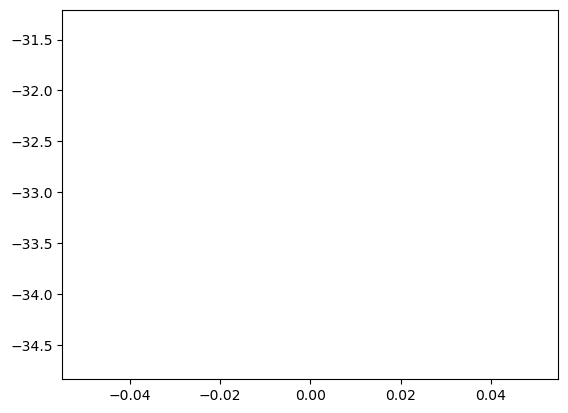

In [25]:
plt.plot(np.cumsum(OPT -ts_rewards_per_experiment[], axis=0), 'r')

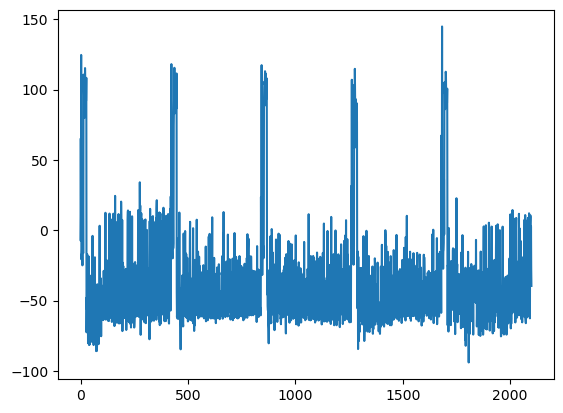

In [11]:
plt.plot(OPT - collected_reward_tss)

In [12]:
#UCB REWARD TOTALE (no reset)

np.random.seed(1000)
n_arms = 4
num_users = 1000
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 1
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_ucb = np.array([])

mu_c0_ucb = [[0 for _ in range(2)] for _ in range(2)]
for e in range(num_experiments):
    env= CG_Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)

    ## LEARN \mu0
    ucb_learner = UCB(n_arms=n_arms)


    pulled_arm_ucb = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    split1_ucb = 0
    split2_ucb = 0

    for d in range(int(n_days*3/14)):
        for d in range(14):

                
            # --------------------------------------------------
            # -------------------THOMSON SAMPLING ---------------
            # --------------------------------------------------
            #ciao

                if split1_ucb==0 and split2_ucb==0:
                        for f1 in range(2):
                            for f2 in range(2):
                                pulled_arm_ucb[f1][f2] = ucb_learner.pull_arm(margins_matrix)

                        reward_ucb = env.round(pulled_arm_ts)  #reward_ts[f1][f2][i]
                        ts_learner.update(pulled_arm_ts[0][0] , reward_ts[0][0], env.clicks_current_day[0][0], env.purchases_current_day[0][0],env.daily_units[0][0])

                    # FIRST DECISION
                if split1_ts==1 and split2_ts==0:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)
                    P = env.E.users_by_class/np.sum(env.E.users_by_class)
                    p_c1 = P[0][0] + P[0][1]
                    p_c2 = P[1][0] + P[1][1]
                    for f1 in range(2):
                        ts_learners[f1].update(pulled_arm_ts[f1][0], (reward_ts[f1][0]*p_c1+reward_ts[f1][1]*p_c2), (env.clicks_current_day[f1][0]+env.clicks_current_day[f1][1]), (env.purchases_current_day[f1][0]+env.purchases_current_day[f1][1]),(env.daily_units[f1][0]+env.daily_units[f1][1]))

                elif split1_ts==1 and split2_ts==1:  # we add the second split
 
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f1][f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].update(pulled_arm_ts[f1][f2], reward_ts[f1][f2], env.clicks_current_day[f1][f2], env.purchases_current_day[f1][f2],env.daily_units[f1][f2])


                elif split1_ts == 0 and split2_ts ==1:
                    pulled_arm_ts = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                    for f1 in range(2):
                        for f2 in range(2):
                            pulled_arm_ts[f1][f2] = ts_learners[f2].pull_arm(margins_matrix)

                    reward_ts = env.round(pulled_arm_ts)

                    for f2 in range(2):
                        ts_learners[f2].update(pulled_arm_ts[0][f2], (reward_ts[0][f2]+reward_ts[1][f2]), (env.clicks_current_day[0][f2]+env.clicks_current_day[1][f2]), (env.purchases_current_day[0][f2]+env.purchases_current_day[1][f2]),(env.daily_units[0][f2]+env.daily_units[1][f2]))


            # DECISION
        if split1_ts==0 and split2_ts==0:
                mu_c0_ts[split1_ts][split2_ts] = np.sum(np.sum(ts_learner.rewards_per_arm))
                #print('mu_c0_ts=',mu_c0_ts)
                # split 1
                collected_reward_tss=np.concatenate((collected_reward_tss, ts_learner.collected_rewards)) #axis=None
                #ts_learners = [ts_learner,ts_learner]
                ts_learner1 = copy.deepcopy(ts_learner)
                ts_learner2 = copy.deepcopy(ts_learner)
                ts_learner1.reset()
                ts_learner2.reset()
                ts_learners = [ts_learner1,ts_learner2]
                split1_ts = 1
                split2_ts = 0

        elif (split1_ts==1 and split2_ts==0):
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[0][1]
                p_c2 = P[1][0] + P[1][1]
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                # we consider the second split
                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                split2_ts = 1  # in ogni caso consideremo la seconds feature
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None
                
                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:

                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner3 = copy.deepcopy(ts_learner)
                    ts_learner4 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learner3.reset()
                    ts_learner4.reset()
                    ts_learners = [[ts_learner1,ts_learner2],[ts_learner3,ts_learner4]]
                    split1_ts = 1
                    #print("--- SPLIT F1 MAKES SENSE ---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learner)
                    ts_learner2 = copy.deepcopy(ts_learner)
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1,ts_learner2]
                    split1_ts = 0
                    #print("--- SPLIT F1 DOESN'T MAKE SENSE ---")

        elif split1_ts==1 and split2_ts==1:

                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0][0].rewards_per_arm))+np.sum(np.sum(ts_learners[1][0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[0][1].rewards_per_arm))+np.sum(np.sum(ts_learners[1][1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0][0].collected_rewards*P[0][0] +
                                                ts_learners[0][1].collected_rewards*P[0][1] +
                                                ts_learners[1][0].collected_rewards*P[1][0] +
                                                ts_learners[1][1].collected_rewards*P[1][1] )
                                                ) #axis=None
                #print('mu_c0_ts=',mu_c0_ts)
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)

                if p_c1*mu_c1 + p_c2*mu_c2 >mu_c0_ts[1][0]:
                    for f1 in range(2):
                        for f2 in range(2):
                            ts_learners[f1][f2].reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (together with f1)---")
                else:
                    ts_learner1 = copy.deepcopy(ts_learners[0][0])
                    ts_learner2 = copy.deepcopy(ts_learner[1][0])
                    ts_learner1.reset()
                    ts_learner2.reset()
                    ts_learners = [ts_learner1 ,ts_learner2]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (we consider only f1)---")

        elif split1_ts == 0 and split2_ts ==1:
                P = env.E.users_by_class/np.sum(env.E.users_by_class)
                p_c1 = P[0][0] + P[1][0]  #p(seconda feature = 0)
                p_c2 = P[0][1] + P[1][1]  #p(seconda feature = 1)
                mu_c1 = np.sum(np.sum(ts_learners[0].rewards_per_arm))
                mu_c2 = np.sum(np.sum(ts_learners[1].rewards_per_arm))

                mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2

                # we consider the second split
                #print('p_c1*mu_c1 + p_c2*mu_c2=',p_c1*mu_c1 + p_c2*mu_c2)
                #print('mu_c0_ts=',mu_c0_ts)
                collected_reward_tss=np.concatenate((collected_reward_tss,
                                                    ts_learners[0].collected_rewards*p_c1 + ts_learners[1].collected_rewards*p_c2)) #axis=None

                if p_c1*mu_c1 + p_c2*mu_c2 > mu_c0_ts[0][0]:
                    ts_learner1.reset()
                    ts_learner2.reset()
                    mu_c0_ts[split1_ts][split2_ts] = p_c1*mu_c1 + p_c2*mu_c2
                    #print("--- SPLIT F2 MAKES SENSE (without f1)---")
                    #ts_learners = [Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)]
                else:
                    ts_learners = [TS_poisson(n_arms=n_arms)]
                    split2_ts = 0
                    #print("--- SPLIT F2 DOESN'T MAKE SENSE (without f1) ---")

    

TypeError: pull_arm() takes 1 positional argument but 2 were given

In [18]:
#SPlit finale
#Random algorithm which for each round pulls a random choice
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

np.random.seed(1000)
n_arms = 4
num_users = 100
n_days = 14*10
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 5
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]
conv_rates_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
mean_units_sold_per_product_per_eperiment = [[[] for _ in range(2)] for _ in range(2)]
cr_learner_expected_rewards_per_experiment = [[[] for _ in range(2)] for _ in range(2)]
collected_reward_crs = np.array([])
opt_vector = [[np.zeros(num_experiments) for _ in range(2)] for _ in range(2)]

for e in range(num_experiments):
    env = [[Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units),Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)] for _ in range(2)]
    ## LEARN \mu0
    cr_learners = [[Conv_rates(n_arms=n_arms),Conv_rates(n_arms=n_arms)] for _ in range(2)]

    pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]


    for d in range(300):
                #pulled_arm_cr = [[np.zeros(5) for _ in range(2)] for _ in range(2)]
                for f1 in range(2):
                    for f2 in range(2):
                        pulled_arm_cr[f1][f2] = cr_learners[f1][f2].pull_arm()

                        reward_cr[f1][f2] = env[f1][f2].round(pulled_arm_cr[f1][f2])

                for f1 in range(2):
                    for f2 in range(2):
                        cr_learners[f1][f2].update(pulled_arm_cr[f1][f2], reward_cr[f1][f2], env[f1][f2].clicks_current_day[f1][f2], env[f1][f2].purchases_current_day[f1][f2],env[f1][f2].daily_units[f1][f2])
                        collected_reward_crs=np.concatenate((collected_reward_crs,
                                                  cr_learners[f1][f2].collected_rewards))

    conversion_rates = [[np.zeros((5,4)) for _ in range(2)] for _ in range(2)]
    np.set_printoptions(suppress=True)

    


    for f1 in range(2):
            for f2 in range(2):
                for i in range(5):
                    conversion_rates[f1][f2][i] = cr_learners[f1][f2].beta_parameters[i][:,0]/(cr_learners[f1][f2].beta_parameters[i][:,0]+cr_learners[f1][f2].beta_parameters[i][:,1])
                    opt_vector[f1][f2][e] += np.max(np.array(E.products[f1][f2][i].margins_list) * conversion_rates[f1][f2][i] * cr_learners[f1][f2].lambda_poisson[i])
                conv_rates_per_experiment[f1][f2].append(conversion_rates[f1][f2])

                mean_units_sold_per_product_per_eperiment[f1][f2].append(cr_learners[f1][f2].lambda_poisson)
                cr_learner_expected_rewards_per_experiment[f1][f2].append(cr_learners[f1][f2].expected_rewards)


opt = [[0 for _ in range(2)] for _ in range(2)]
opt2 = [[0 for _ in range(2)] for _ in range(2)]
for f1 in range(2):
    for f2 in range(2):
        opt[f1][f2] = np.mean(opt_vector[f1][f2]) #+ np.std(opt_vector)
        opt2[f1][f2] = np.min(opt_vector[f1][f2])


best_arm_per_product = [[np.zeros(5) for i in range(2)] for i in range(2)]
for f1 in range(2):
    for f2 in range(2):

        for i in range(5):   
            best_arm_per_product[f1][f2][i] = np.argmax(np.array(E.products[f1][f2][i].margins_list) * np.mean(conv_rates_per_experiment[f1][f2],axis=0)[i] 
                                                * np.mean(mean_units_sold_per_product_per_eperiment[f1][f2], axis = 0)[i])#expected_units_sold_per_product[i])#

        

AttributeError: 'list' object has no attribute 'change_price'

In [35]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes
products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
expected_units_sold_per_product = np.array([2,1,3,3,1]) #theese are the lambdas defined in the visit function
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
E = E_commerce(binary_features=1)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

In [40]:
#Random algorithm which for each round pulls a random choice 
#to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
#useful for computing clairvoyant solution and regrets of the bandit algorithms

n_arms = 4
num_users = 100
n_days = 365
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
num_experiments = 5
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_eperiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()#best_arm_per_product=np.array([2., 1., 1., 1., 0.]), clairvoyant_flag=1)
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_eperiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given chosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i] 
                                        * np.mean(mean_units_sold_per_product_per_eperiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected rewards per arm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_eperiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms




_______________________________________________
Conversion rates
[[0.5        0.5        0.62103415 0.5       ]
 [0.5        0.81731325 0.5        0.5       ]
 [0.5        0.79459259 0.5        0.5       ]
 [0.5        0.80541987 0.5        0.5       ]
 [0.99752598 0.5        0.5        0.5       ]]
_______________________________________________
Expected rewards per arm
[[ 0.          0.         10.24732729  0.        ]
 [ 0.          7.13010838  0.          0.        ]
 [ 0.         26.24516123  0.          0.        ]
 [ 0.         50.67014798  0.          0.        ]
 [38.20210712  0.          0.          0.        ]]
_______________________________________________
Expected units sold per arm
[[0.         0.         2.00098204 0.        ]
 [0.         1.         0.         0.        ]
 [0.         2.98962452 0.         0.        ]
 [0.         3.00450633 0.         0.        ]
 [1.         0.         0.         0.        ]]
_______________________________________________
Best confi

In [41]:
opt

132.34850807697077

In [42]:
best_arm_per_product

array([2., 1., 1., 1., 0.])

In [ ]:
#TS class 0

E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

In [ ]:
#TS class 0 + 1

E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 100
n_days = 1000
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 10

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gr_rewards_per_experiment = []
cr_rewards_per_experiment = []

ts_pulls_per_arm_per_experiment = []
ucb_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)
    ucb_pulls_per_arm_per_experiment.append(ucb_learner.counter_per_arm)

In [70]:
#TS class 0 + 1 + 2

E = E_commerce(binary_features=30)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30
n_days = 140
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 2

ts3_rewards_per_experiment = []
ts3_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts3_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts3_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)




E = E_commerce(binary_features=20)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 40
n_days = 140
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 2

ts2_rewards_per_experiment = []


ts2_pulls_per_arm_per_experiment = []



for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts2_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts2_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)



E = E_commerce(binary_features=10)
E.set_lambda(0.5)
E.set_products(products)
E.graph = np.array([[0. , 0.5, 0. , 1. , 0. ],[1. , 0. , 0. , 0.5, 0. ],[0. , 1. , 0. , 0.5, 0. ],[0. , 0.5, 1. , 0. , 0. ],[1. , 0. , 0. , 0.5, 0. ]])

n_arms = 4
num_users = 30
n_days = 140
fixed_alpha = 0
fixed_weights = 1
fixed_units = 0
n_experiments = 2

ts1_rewards_per_experiment = []


ts1_pulls_per_arm_per_experiment = []


for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS_poisson(n_arms=n_arms)

    for d in range(n_days):
        
        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)

    ts1_rewards_per_experiment.append(ts_learner.collected_rewards)

    ts1_pulls_per_arm_per_experiment.append(ts_learner.counter_per_arm)


In [71]:
print("TS",np.mean(np.mean(ts1_rewards_per_experiment, axis=0)), np.std(np.mean(ts1_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts2_rewards_per_experiment, axis=0)), np.std(np.mean(ts2_rewards_per_experiment, axis=0)))
print("TS",np.mean(np.mean(ts3_rewards_per_experiment, axis=0)), np.std(np.mean(ts3_rewards_per_experiment, axis=0)))

TS 129.0575379761905 25.882395314881546
TS 126.68888321428572 23.990789643641957
TS 127.19413089285715 21.68926580357335


In [72]:
0.3*np.mean(np.mean(ts1_rewards_per_experiment, axis=0))+0.4*np.mean(np.mean(ts2_rewards_per_experiment, axis=0))+0.3*np.mean(np.mean(ts3_rewards_per_experiment, axis=0))

127.55105394642858

In [75]:
ts_all_classes_rewards = 0.3*(np.mean(ts1_rewards_per_experiment, axis=0))+0.4*(np.mean(ts2_rewards_per_experiment, axis=0))+0.3*np.mean(ts3_rewards_per_experiment, axis=0)

In [76]:
opt

132.34850807697077

In [79]:
ts_all_classes_rewards- opt

array([  -7.15899974,  -41.75875808,  -98.87480808, -132.34850808,
        -12.51273308,   -5.28630808,  -20.29250808,    2.85771692,
        -22.05870141,   -8.43010808,   -9.88646641,  -12.98094141,
        -29.36678308,    0.93184192,   -7.38064141,   -0.13740808,
         -6.81685808,   12.10647526,   -9.51083308,  -16.85990808,
         -2.73295808,   -6.81370808,   -1.69629974,    9.63154192,
         -5.99560808,  -16.27199141,   -7.87475808,   -5.00477474,
        -22.03319974,   14.10532109,    0.54658359,   -6.09203308,
         12.92046692,    4.86684192,  -10.73570808,    0.32830859,
          3.98043359,    4.95974192,   10.36295859,   -2.82248308,
          6.69960859,  -18.62345808,    2.28210026,   -8.90746641,
          7.01224192,    0.47720859,   14.52696692,   -9.21118308,
         -6.52639974,    3.66096692,   -9.51478308,    3.20591692,
         -8.23743308,  -10.30258308,    9.21389192,  -17.01736641,
          2.13719192,   -3.06165808,   15.63804192,    4.50896

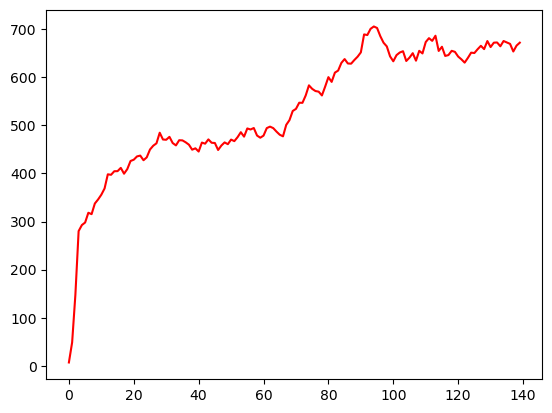

In [80]:
plt.plot(np.cumsum(opt-ts_all_classes_rewards, axis=0), 'r')